In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [53]:

import sys
import os
sys.path.append('../..')

#Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [54]:
FOLDER_OUTPUT = f'runs/fitted_graphs_comparison_reddit2'
out_files = os.listdir(FOLDER_OUTPUT)
out_files = sorted(out_files, key=lambda x: os.path.getctime(os.path.join(FOLDER_OUTPUT, x)), reverse=True)

out_files

['comparators_component_27556.pkl',
 'comparators_component_7632.pkl',
 'comparators_component_29275.pkl',
 'comparators_component_17743.pkl',
 'comparators_component_18245.pkl',
 'comparators_component_3586.pkl',
 'comparators_component_5917.pkl',
 'comparators_component_30101.pkl',
 'comparators_component_30635.pkl',
 'comparators_component_11002.pkl',
 'comparators_component_5576.pkl',
 'comparators_component_6932.pkl',
 'comparators_component_6658.pkl',
 'comparators_component_6601.pkl',
 'comparators_component_4899.pkl',
 'comparators_component_21698.pkl',
 'comparators_component_29885.pkl',
 'comparators_component_6642.pkl',
 'comparators_component_10792.pkl',
 'comparators_component_6699.pkl']

In [55]:
import pickle
#pick first id from out_files
id = out_files[0].split('_')[-1]

with open(f'{FOLDER_OUTPUT}/comparators_component_{id}', 'rb') as f:
    comparators = pickle.load(f)


In [56]:
len(comparators)

20

In [57]:
dfs = []
for i in range(len(comparators)):
    dfs.append(comparators[i].summary_df)

In [58]:
dfs[1]

graph_filename     model  gic_value               param  \
0  component_10792.edges  Original        NaN                 N/A   
1  component_10792.edges        LG   0.612333  d=0, sigma=-1.2097   
2  component_10792.edges        WS   0.810729           20.157778   
3  component_10792.edges        BA   1.600987                 3.0   
4  component_10792.edges        ER   5.511961            0.031111   
5  component_10792.edges       GRG   6.259643                 1.0   

   fit_success  nodes    edges   density  avg_clustering  avg_path_length  \
0         True   1877     2100  0.001193        0.027560         3.659675   
1         True   1877     2149  0.001221        0.000000         8.585743   
2         True   1877     1877  0.001066        0.000000        29.587611   
3         True   1877     5622  0.003193        0.019010         3.701178   
4         True   1877    54896  0.031180        0.031291         2.125149   
5         True   1877  1719639  0.976720        0.979548         1.023280   

   diameter  assortativity  num_components  largest_component_size  
0        12      -0.333175               1                    1877  
1        23      -0.029929             225                    1628  
2        77      -0.199273               3                    1237  
3         6      -0.067247               1                    1877  
4         3       0.000613               1                    1877  
5         2      -0.032594               1                    1877

In [59]:
pd.concat(dfs)

graph_filename     model  gic_value               param  \
0    component_6699.edges  Original        NaN                 N/A   
1    component_6699.edges        LG   0.244557  d=0, sigma=-1.7434   
2    component_6699.edges        WS   0.411193                20.2   
3    component_6699.edges        BA   1.982833            3.222222   
4    component_6699.edges        ER   5.923369                0.01   
..                    ...       ...        ...                 ...   
1   component_27556.edges        LG   0.346813  d=1, sigma=-8.1290   
2   component_27556.edges        WS   0.521576                20.2   
3   component_27556.edges        BA   1.980660            3.444444   
4   component_27556.edges        ER   6.842491            0.031111   
5   component_27556.edges       GRG   8.534613                 1.0   

    fit_success  nodes   edges   density  avg_clustering  avg_path_length  \
0          True   1142    1456  0.002235        0.023550         4.557473   
1          True   1142    1436  0.002204        0.001747         6.889021   
2          True   1142    1142  0.001753        0.000000        39.960154   
3          True   1142    3417  0.005245        0.025999         3.542591   
4          True   1142    6712  0.010302        0.010759         3.117665   
..          ...    ...     ...       ...             ...              ...   
1          True   1161    1379  0.002048        0.001637         6.581872   
2          True   1161    1161  0.001724        0.001292        44.606630   
3          True   1161    3474  0.005159        0.023570         3.610502   
4          True   1161   20765  0.030837        0.030766         2.290604   
5          True   1161  659221  0.978973        0.981458         1.021027   

    diameter  assortativity  num_components  largest_component_size  
0         12      -0.142123               1                    1142  
1         16      -0.050725             141                     996  
2        131      -0.204026               1                    1142  
3          6      -0.084250               1                    1142  
4          5      -0.020964               1                    1142  
..       ...            ...             ...                     ...  
1         14       0.009986             204                     933  
2        114      -0.203336               2                    1149  
3          6      -0.070460               1                    1161  
4          3      -0.000182               1                    1161  
5          2      -0.033440               1                    1161  

[120 rows x 14 columns]

In [60]:
# Create a DataFrame with GIC values for each model and graph
gic_df = pd.DataFrame()

for df in dfs:
    graph_name = df['graph_filename'].iloc[0]
    # Get GIC values for each model (excluding Original which has NaN)
    model_gics = df[df['model'] != 'Original'].set_index('model')['gic_value']
    gic_df[graph_name] = model_gics

# Transpose so graphs are rows and models are columns
gic_df = gic_df.T
gic_df

model                        LG        WS        BA        ER        GRG
component_6699.edges   0.244557  0.411193  1.982833  5.923369   9.972620
component_10792.edges  0.612333  0.810729  1.600987  5.511961   6.259643
component_6642.edges   0.417722  0.598862  1.681336  7.035045   8.252000
component_29885.edges  0.144611  0.433723  0.967287  5.032935  11.381969
component_21698.edges  0.631885  0.771421  2.015998  5.546825   6.287364
component_4899.edges   0.530453  0.712119  1.490153  5.817256   7.171943
component_6601.edges   0.451602  0.580611  2.206783  6.916765   7.829799
component_6658.edges   0.267538  0.446672  2.091538  7.983214   9.534530
component_6932.edges   0.509357  0.668688  1.992590  5.943873   7.002457
component_5576.edges   0.277406  0.425681  2.078119  8.109178   9.577402
component_11002.edges  0.894898  1.246550  2.702900  3.050822   3.404358
component_30635.edges  0.264590  0.487911  1.565860  7.787361   9.664817
component_30101.edges  0.132467  0.322782  1.593375  5.766954  11.524220
component_5917.edges   0.425737  0.599852  1.882538  6.565929   7.818188
component_3586.edges   0.519911  0.689472  1.867872  6.067109   6.991031
component_18245.edges  1.347992  1.484556  1.918527  1.799881   2.322537
component_17743.edges  0.413554  0.617544  1.293985  6.750675   8.453018
component_29275.edges  0.461222  0.645500  2.493329  6.062908   7.640761
component_7632.edges   0.539280  0.746377  1.727687  6.027299   6.718353
component_27556.edges  0.346813  0.521576  1.980660  6.842491   8.534613

In [61]:
# Create a dictionary to store rankings for each graph
rankings = {}

# Go through each df in dfs
for df in dfs:
    graph_name = df['graph_filename'].iloc[0]  # Get graph filename
    
    # Sort models by GIC value (excluding 'Original' which has NaN GIC)
    model_ranks = df[df['model'] != 'Original'].sort_values('gic_value')['model'].tolist()
    
    # Create rankings dictionary for this graph (1 is best since lowest GIC is best)
    rankings[graph_name] = {
        model: rank+1 for rank, model in enumerate(model_ranks)
    }
    
    # Add nodes and edges from Original model
    original_row = df[df['model'] == 'Original'].iloc[0]
    rankings[graph_name]['nodes'] = original_row['nodes']
    rankings[graph_name]['edges'] = original_row['edges']

# Get unique models (excluding 'Original')
models = sorted(list(set([model for df in dfs for model in df['model'].unique() if model != 'Original'])))

# Create DataFrame with rankings
ranking_df = pd.DataFrame(rankings).T

# Ensure all models are present as columns
for model in models:
    if model not in ranking_df.columns:
        ranking_df[model] = np.nan

# Keep only the model columns in a consistent order, plus nodes and edges
ranking_df = ranking_df[models + ['nodes', 'edges']]

print("Rankings by GIC value (lower is better):")
display(ranking_df)


Rankings by GIC value (lower is better):


BA  ER  GRG  LG  WS  nodes  edges
component_6699.edges    3   4    5   1   2   1142   1456
component_10792.edges   3   4    5   1   2   1877   2100
component_6642.edges    3   4    5   1   2   1918   2285
component_29885.edges   3   4    5   1   2   1747   2866
component_21698.edges   3   4    5   1   2   1601   1762
component_4899.edges    3   4    5   1   2   1474   1749
component_6601.edges    3   4    5   1   2   1243   1367
component_6658.edges    3   4    5   1   2   1400   1737
component_6932.edges    3   4    5   1   2   1469   1649
component_5576.edges    3   4    5   1   2   1142   1370
component_11002.edges   3   4    5   1   2   3421   3656
component_30635.edges   3   4    5   1   2   1461   1945
component_30101.edges   3   4    5   1   2   1190   1606
component_5917.edges    3   4    5   1   2   1247   1458
component_3586.edges    3   4    5   1   2   1012   1112
component_18245.edges   4   3    5   1   2   1432   1493
component_17743.edges   3   4    5   1   2   1307   1681
component_29275.edges   3   4    5   1   2   1017   1237
component_7632.edges    3   4    5   1   2   1262   1430
component_27556.edges   3   4    5   1   2   1161   1416

In [62]:
ranking_df.mean(axis=0)

BA          3.05
ER          3.95
GRG         5.00
LG          1.00
WS          2.00
nodes    1476.15
edges    1768.75
dtype: float64

In [63]:
ranking_df['nodes'].describe()

count      20.000000
mean     1476.150000
std       525.529435
min      1012.000000
25%      1182.750000
50%      1353.500000
75%      1505.750000
max      3421.000000
Name: nodes, dtype: float64

In [51]:
len(ranking_df)

7

# Gen all Plots

gplus_0


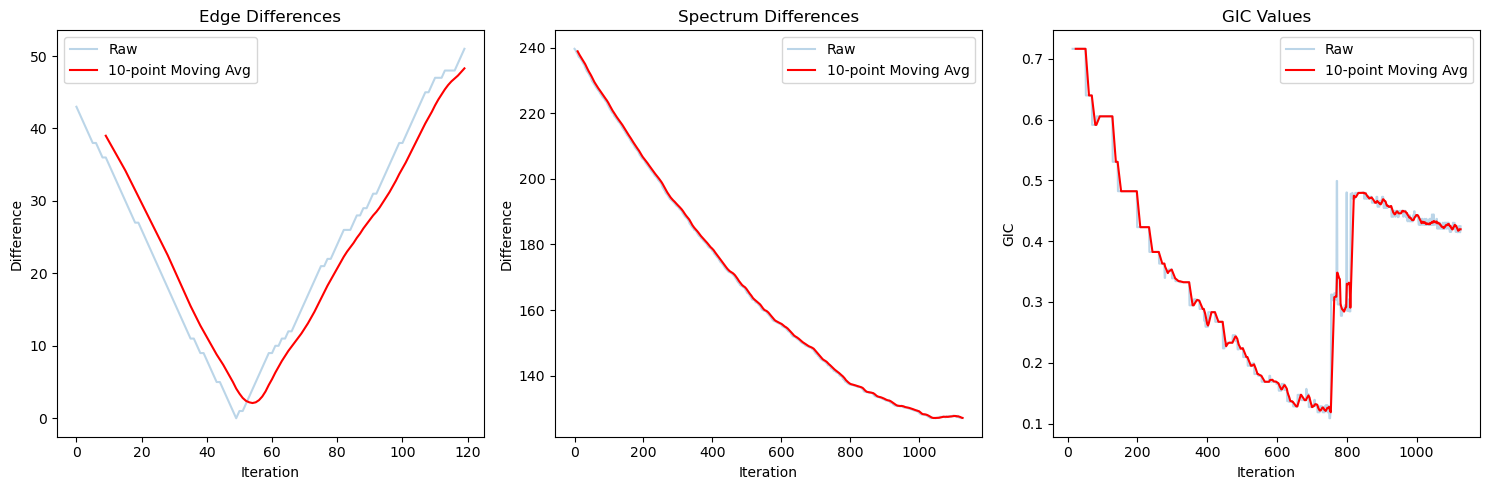

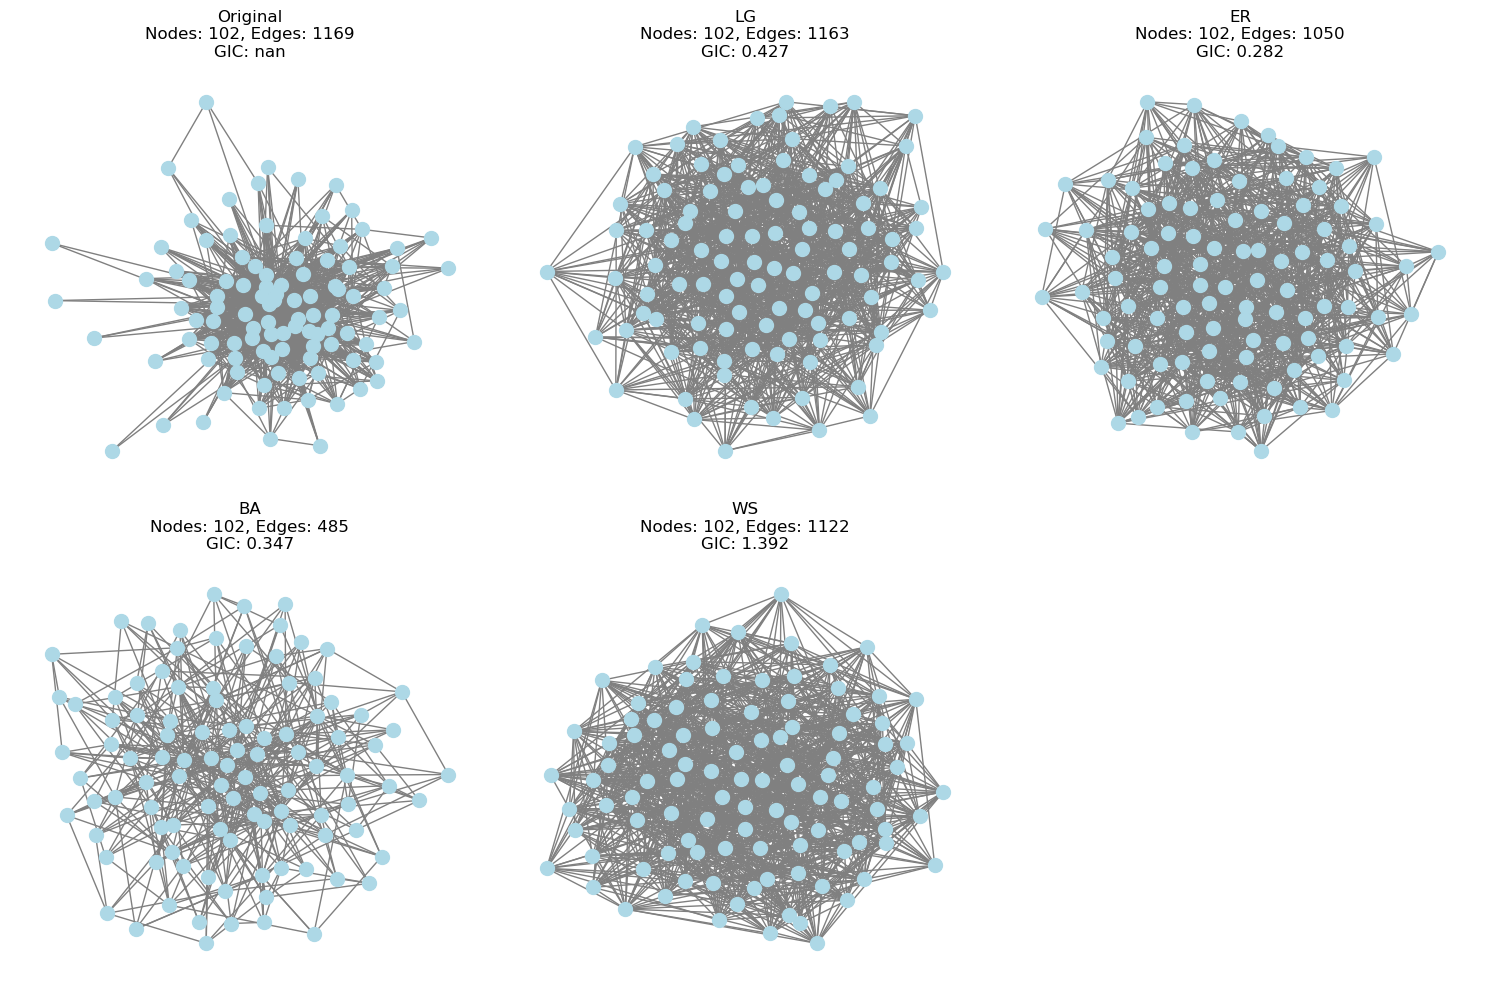

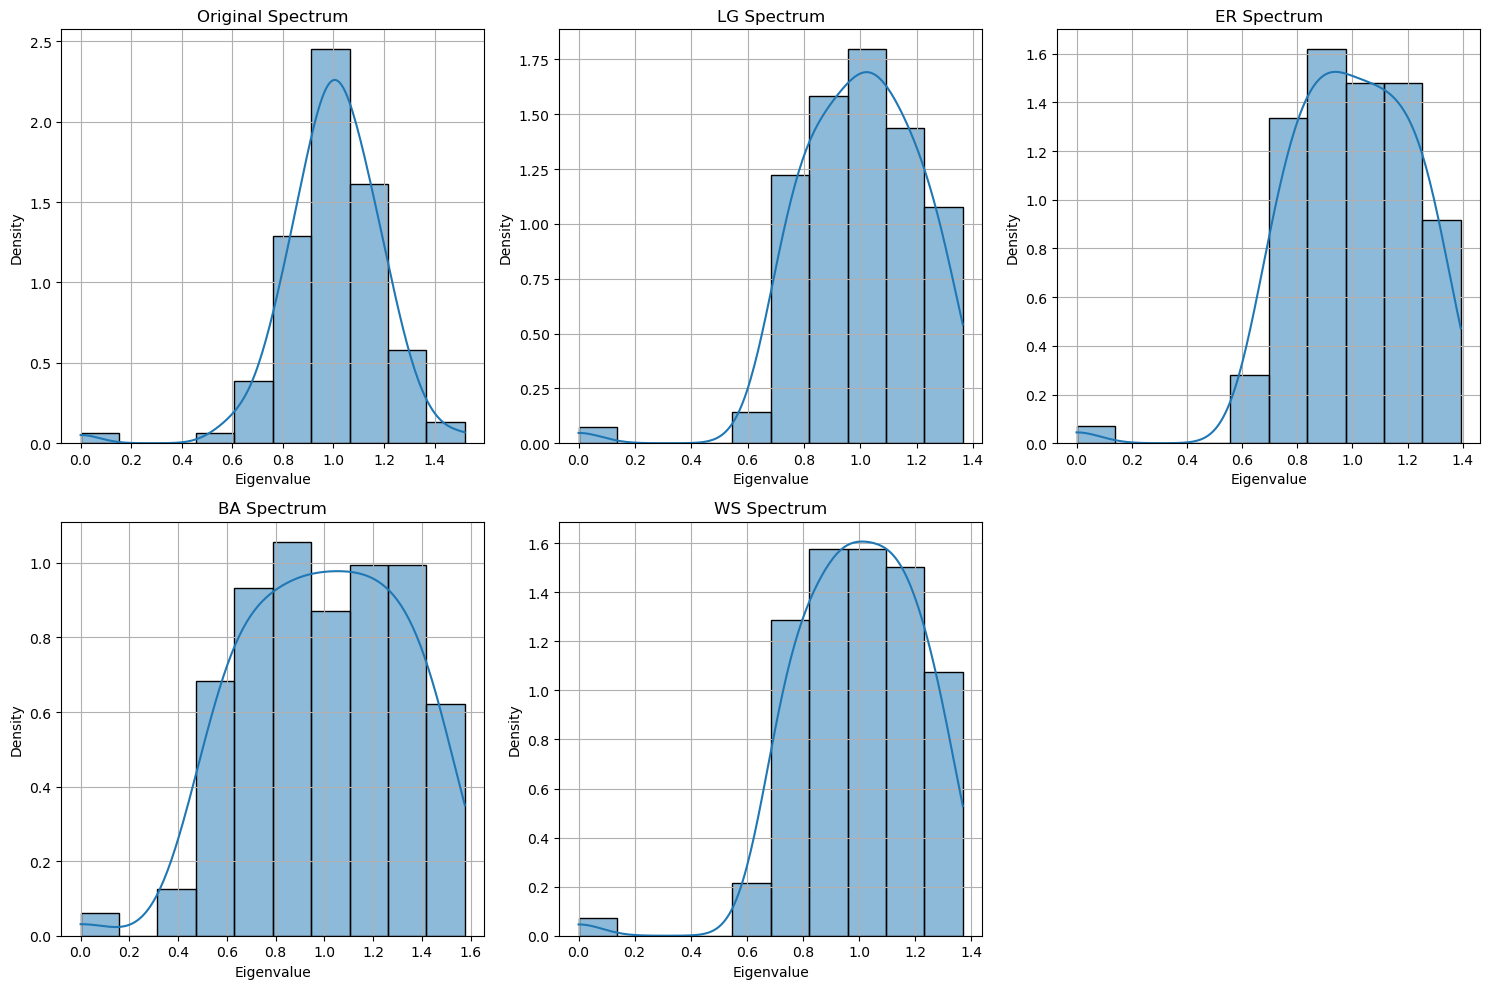

gplus_1


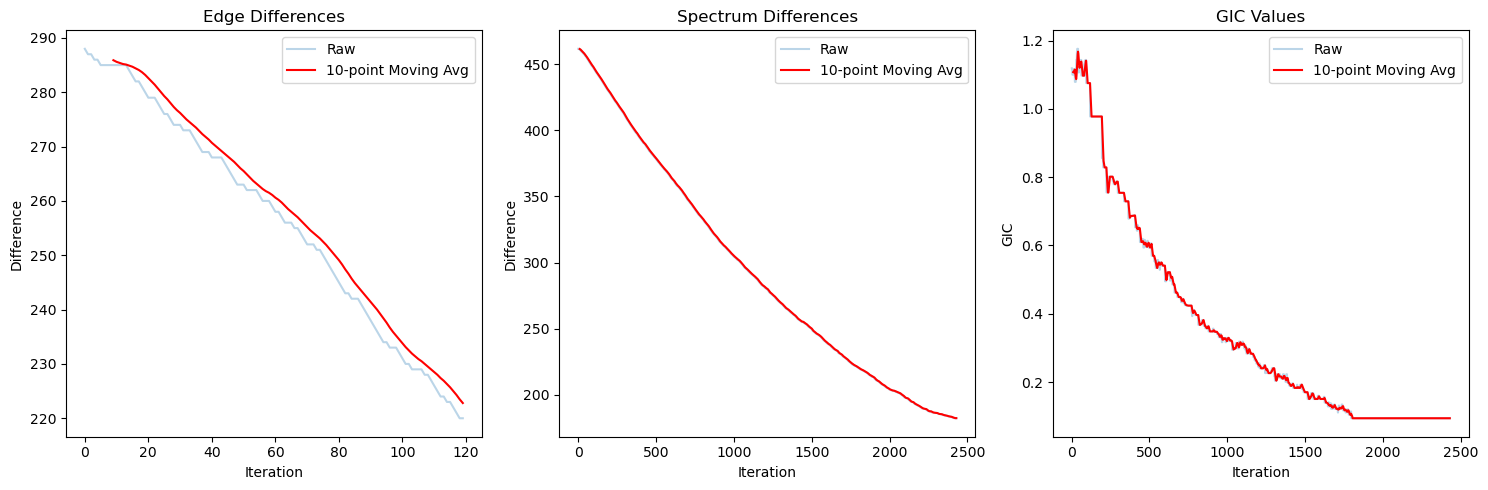

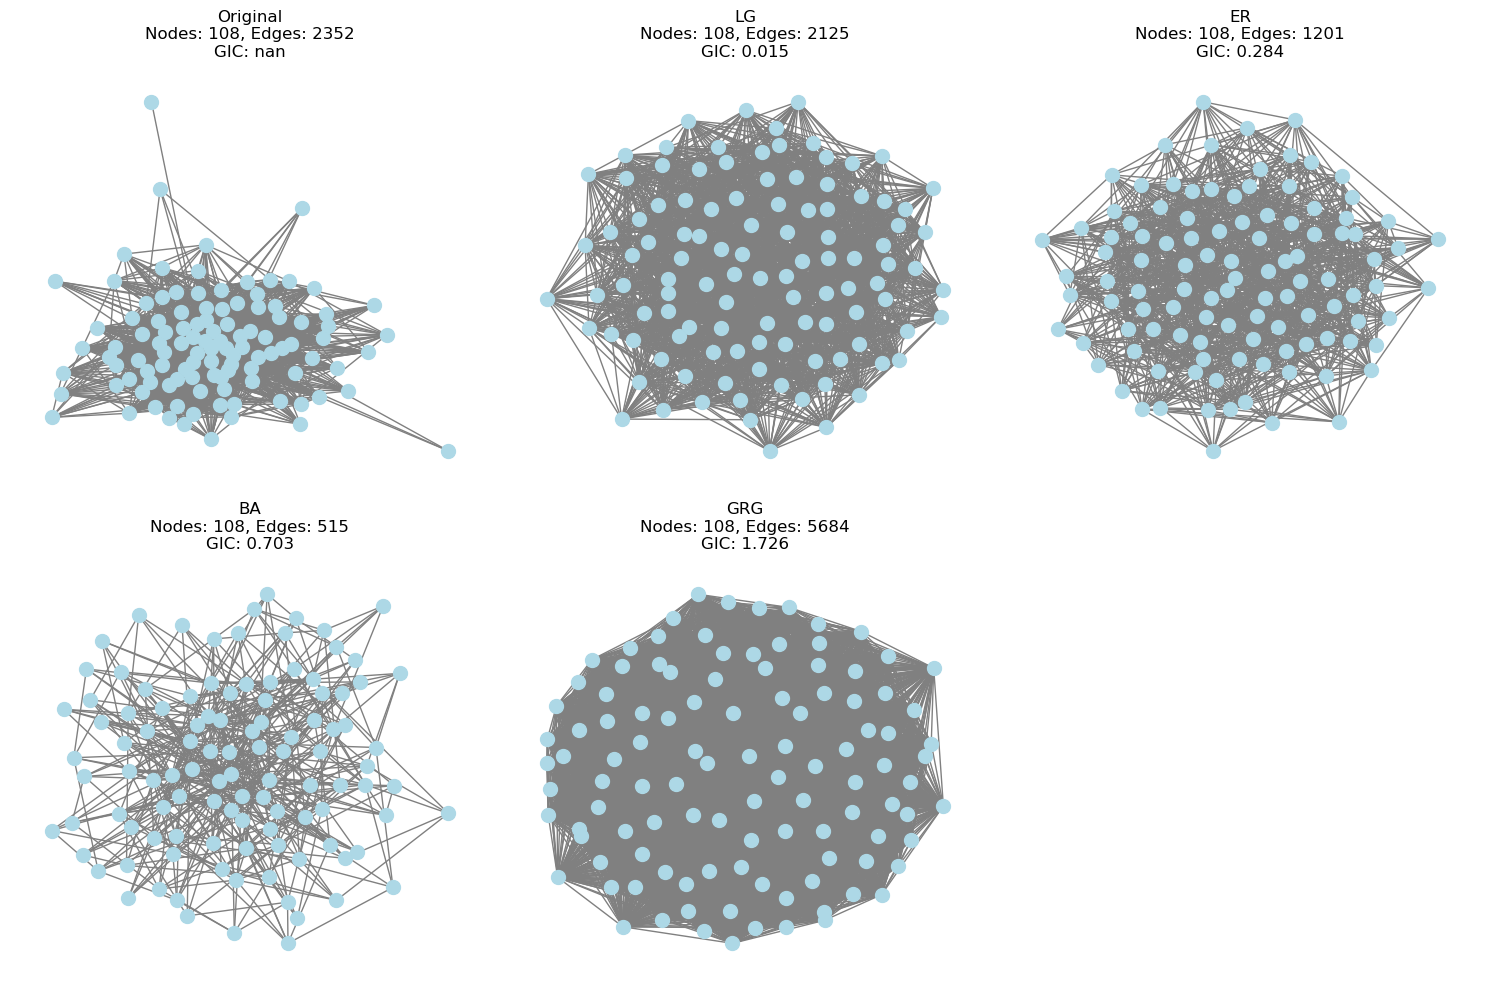

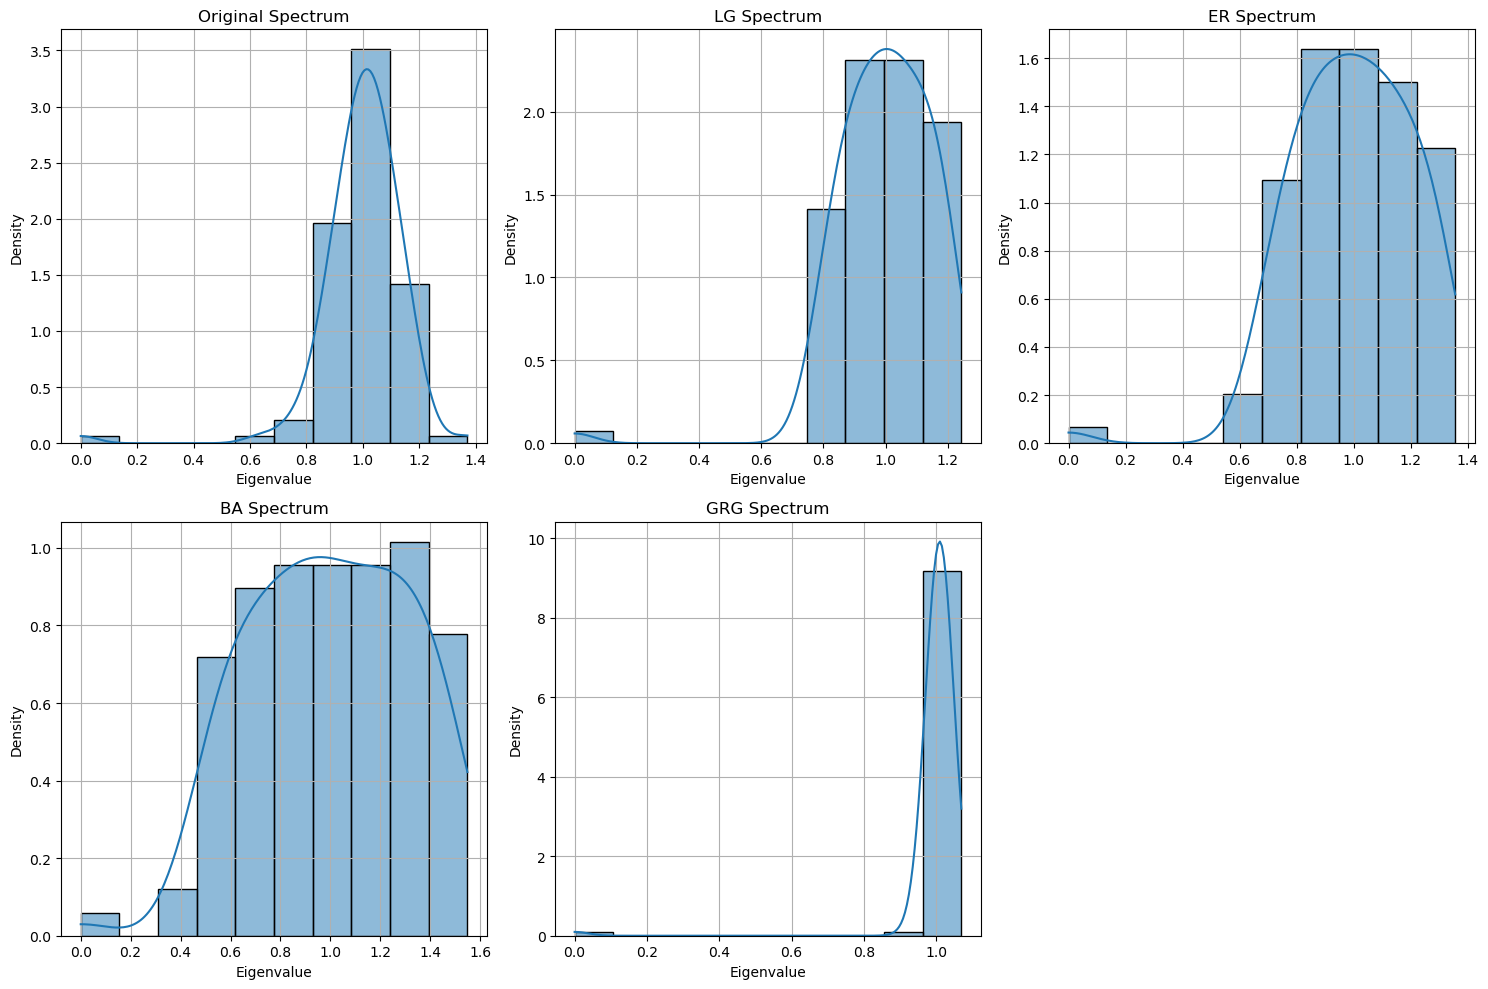

gplus_2


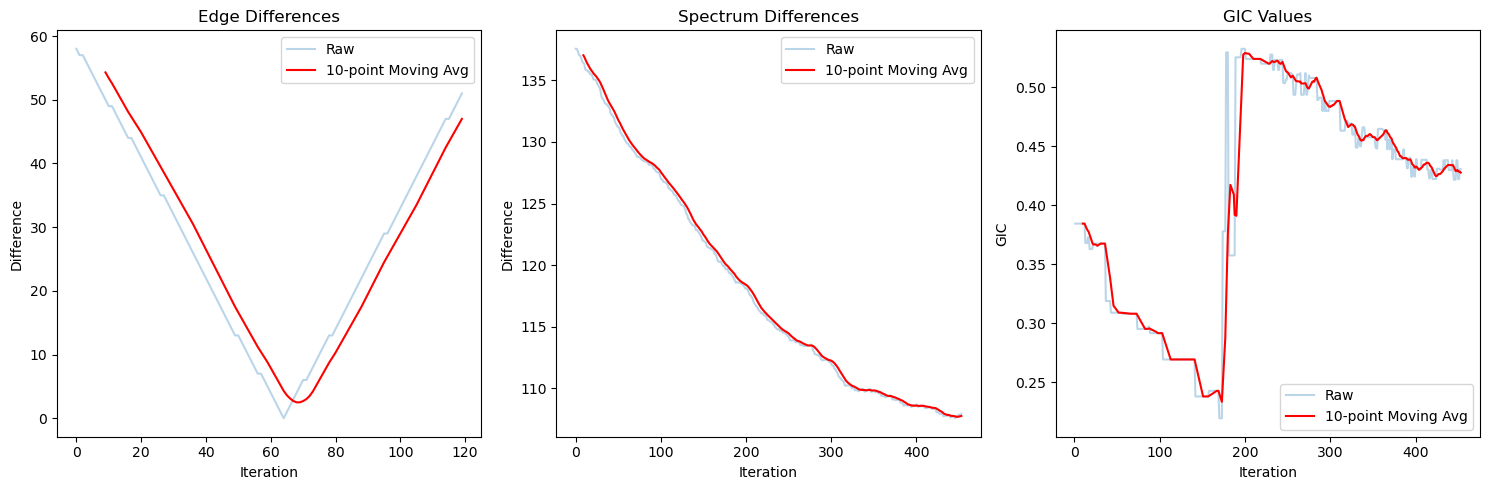

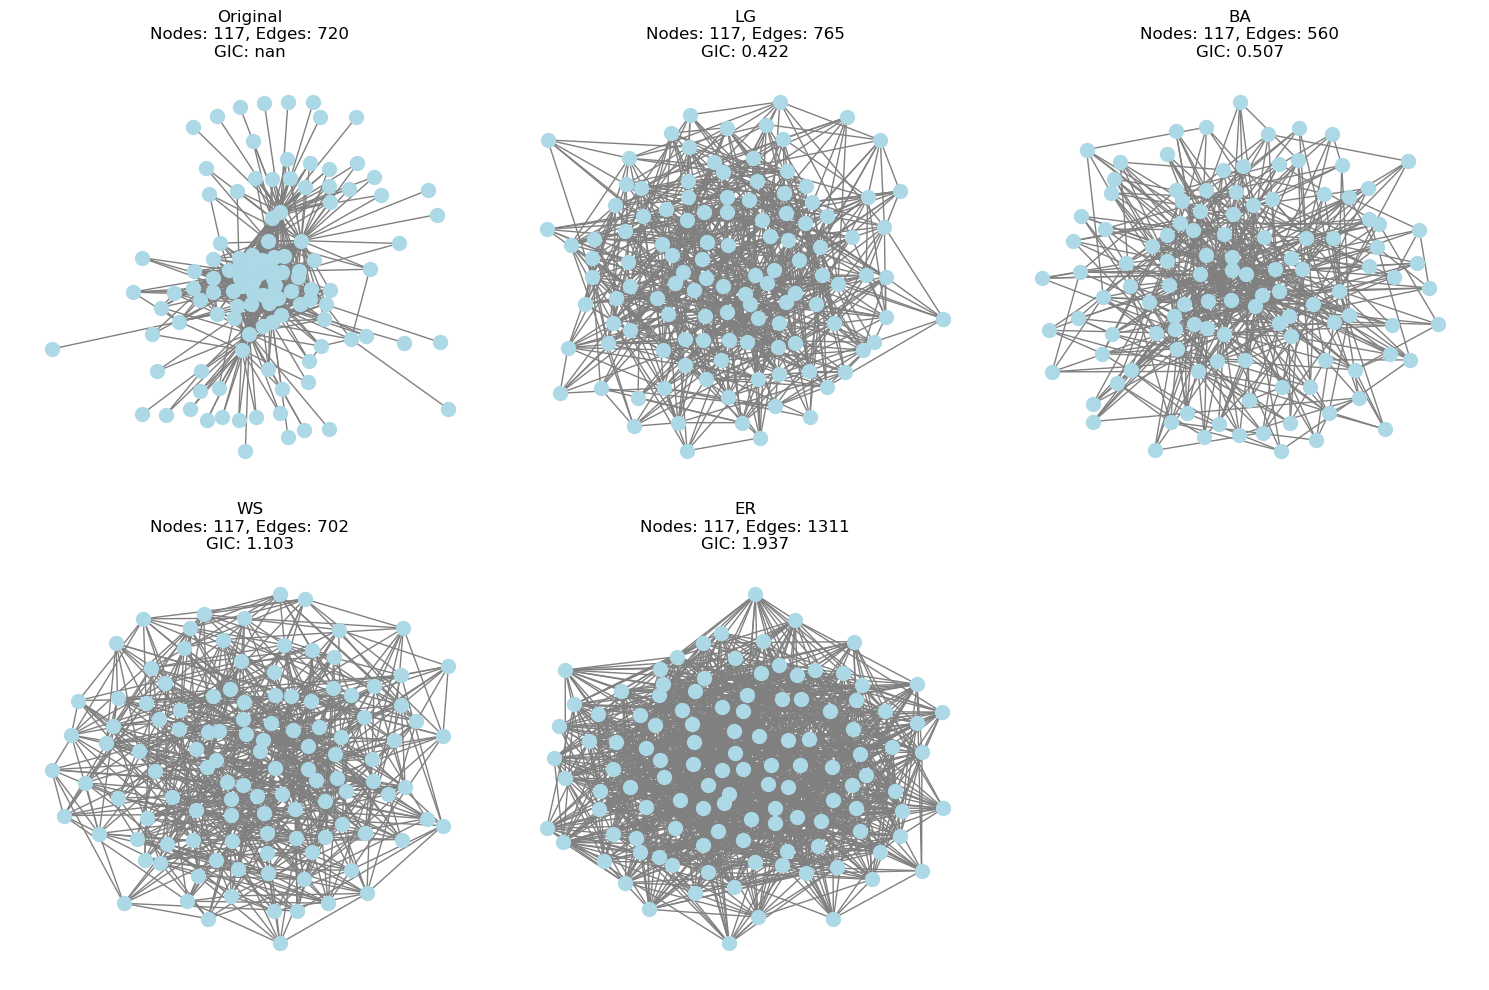

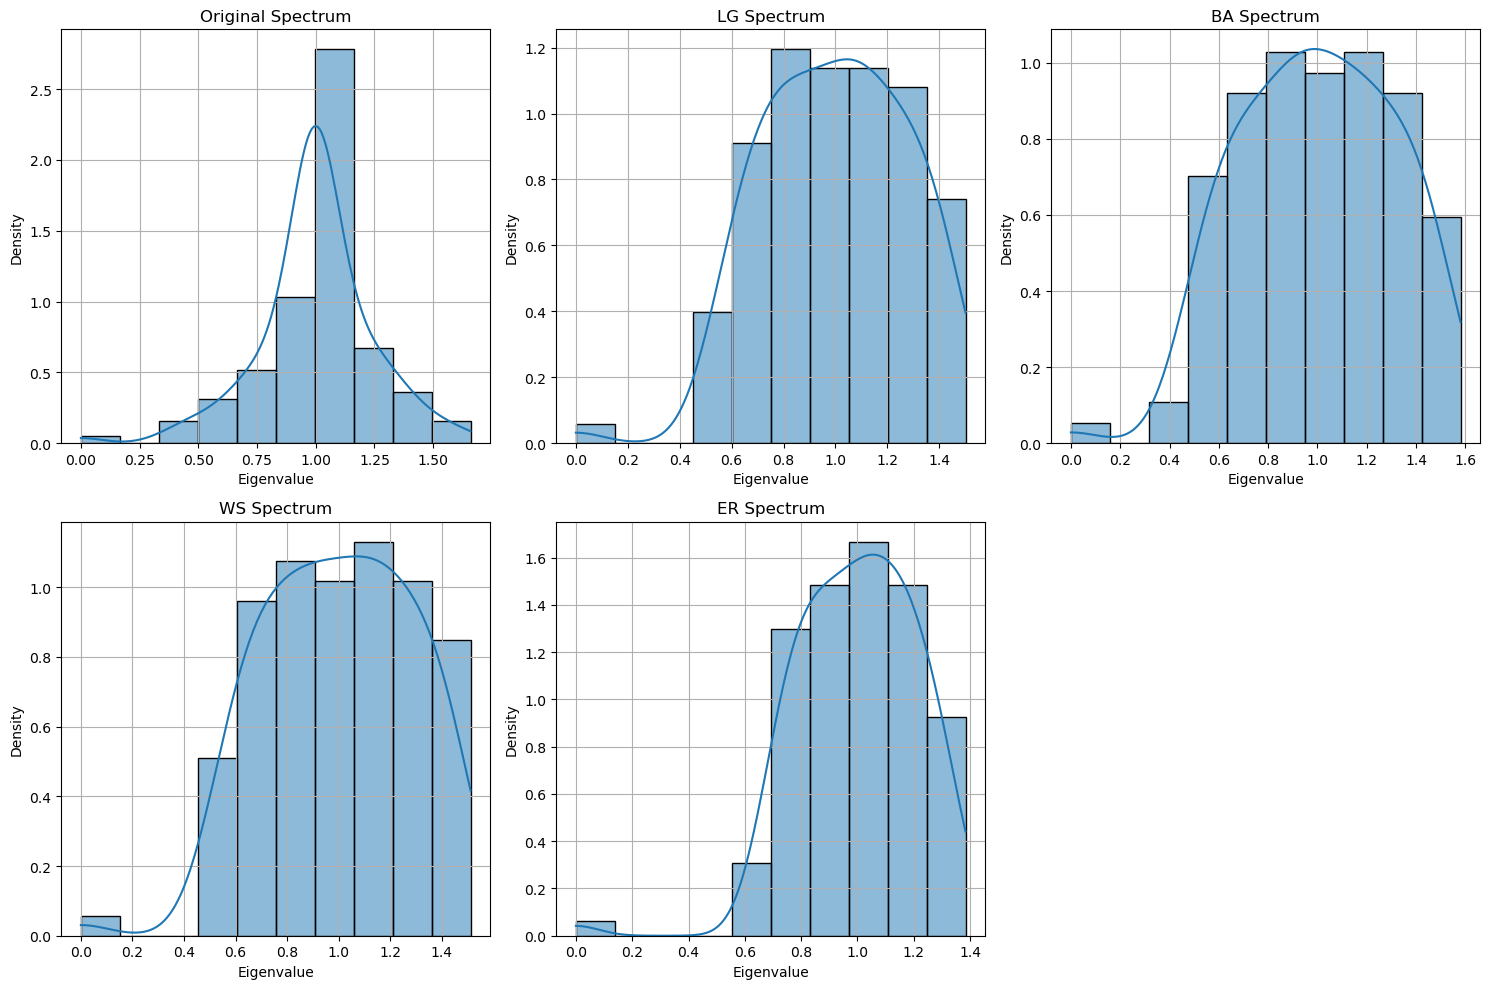

gplus_3


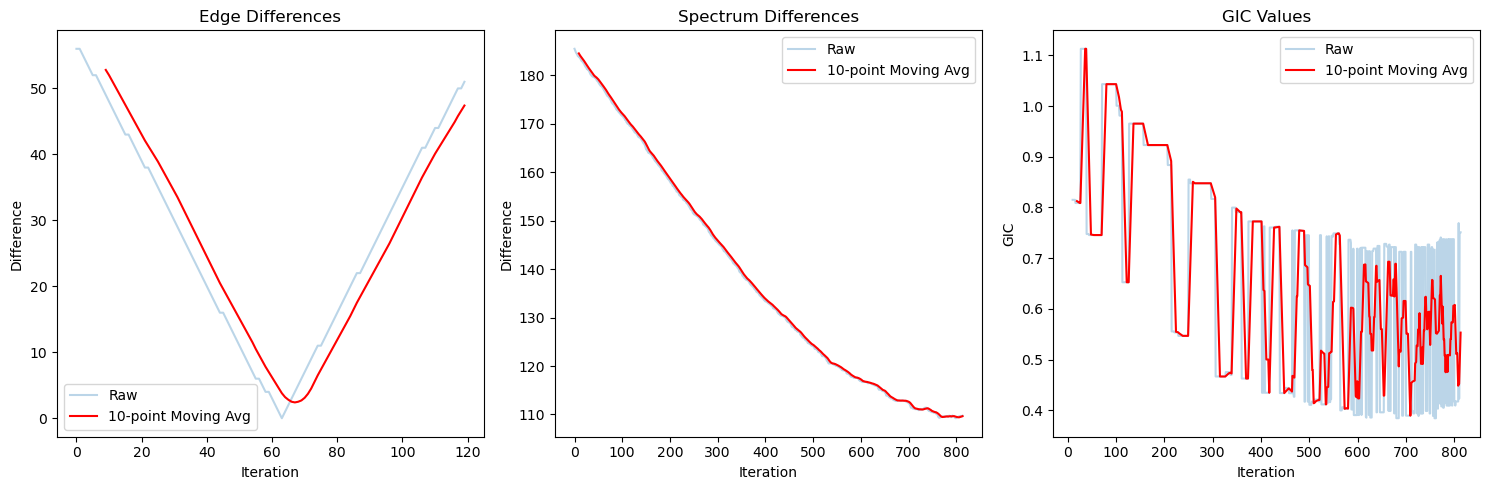

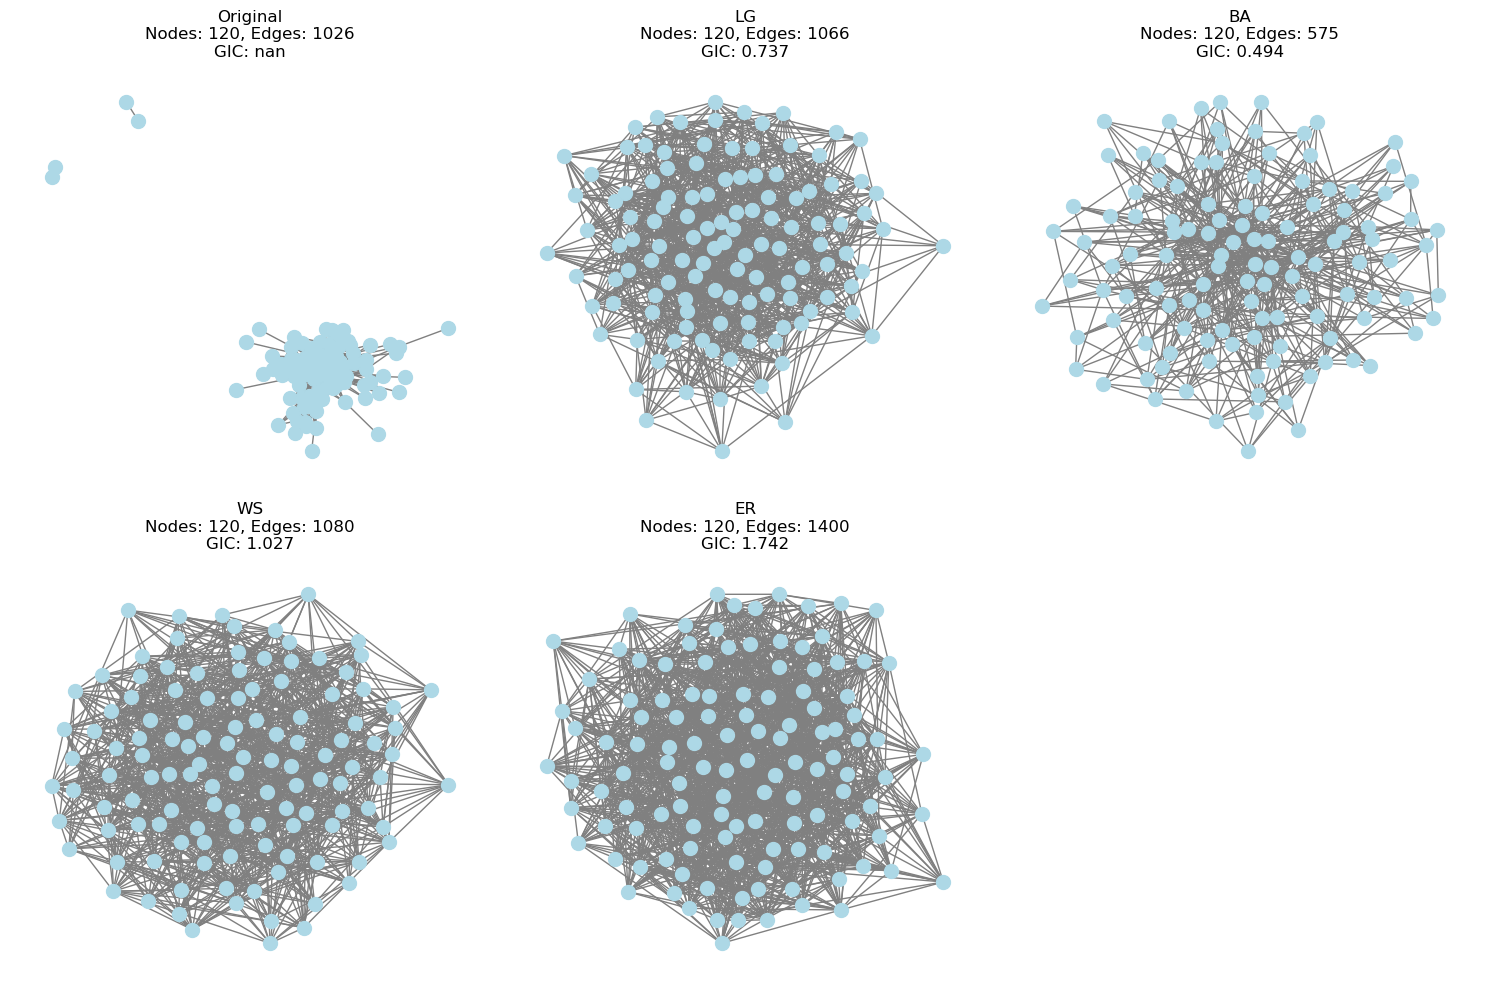

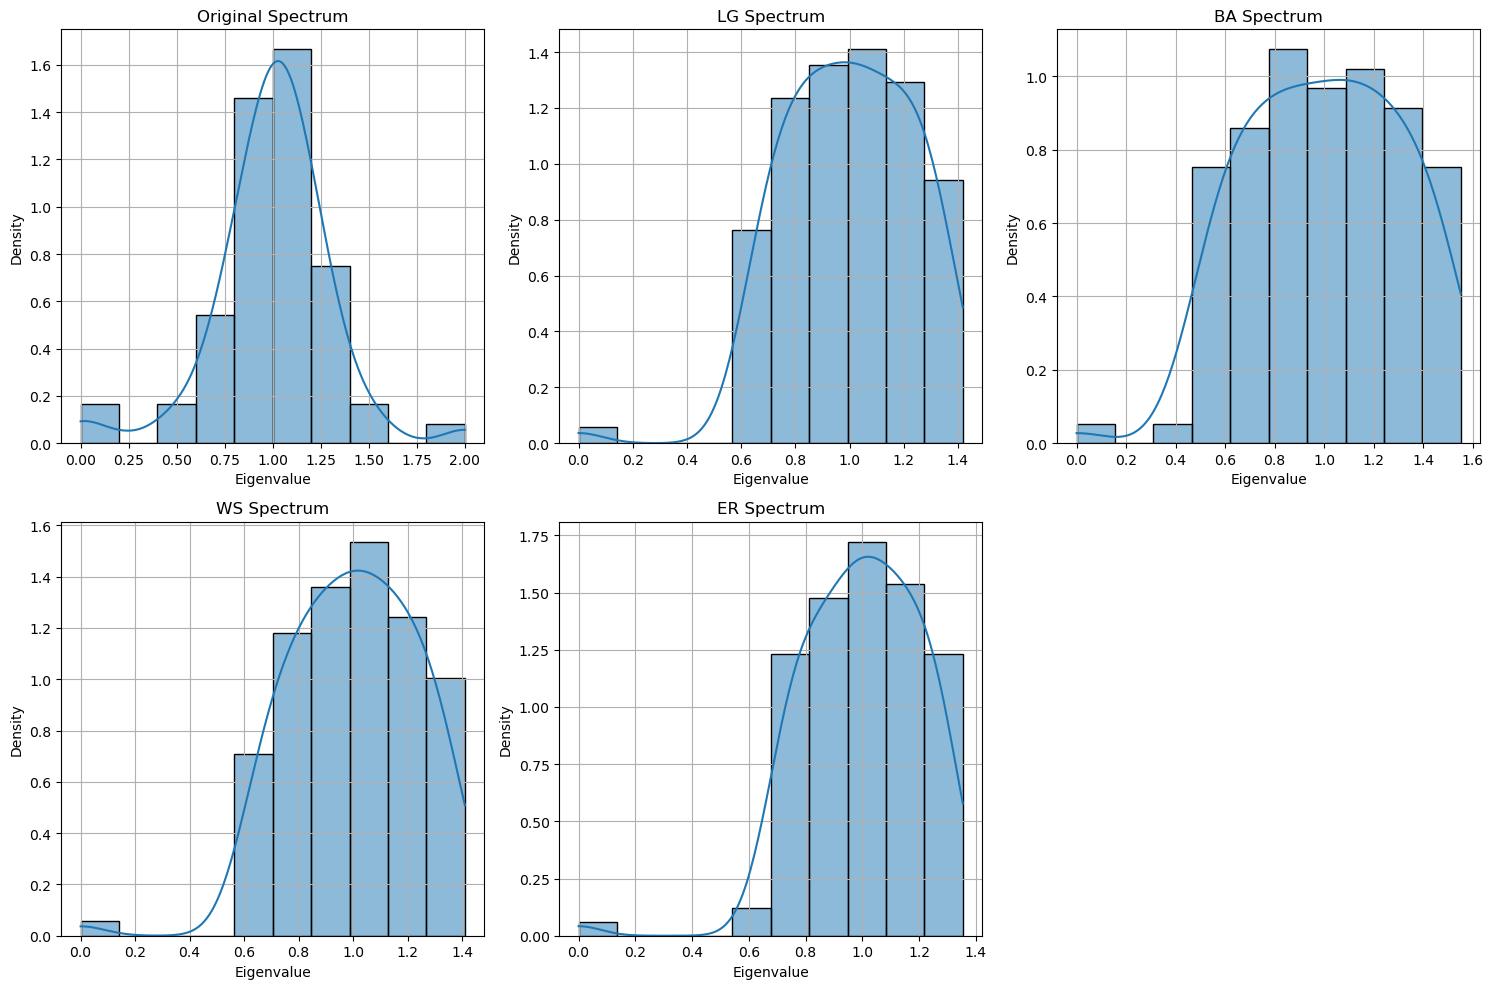

gplus_4


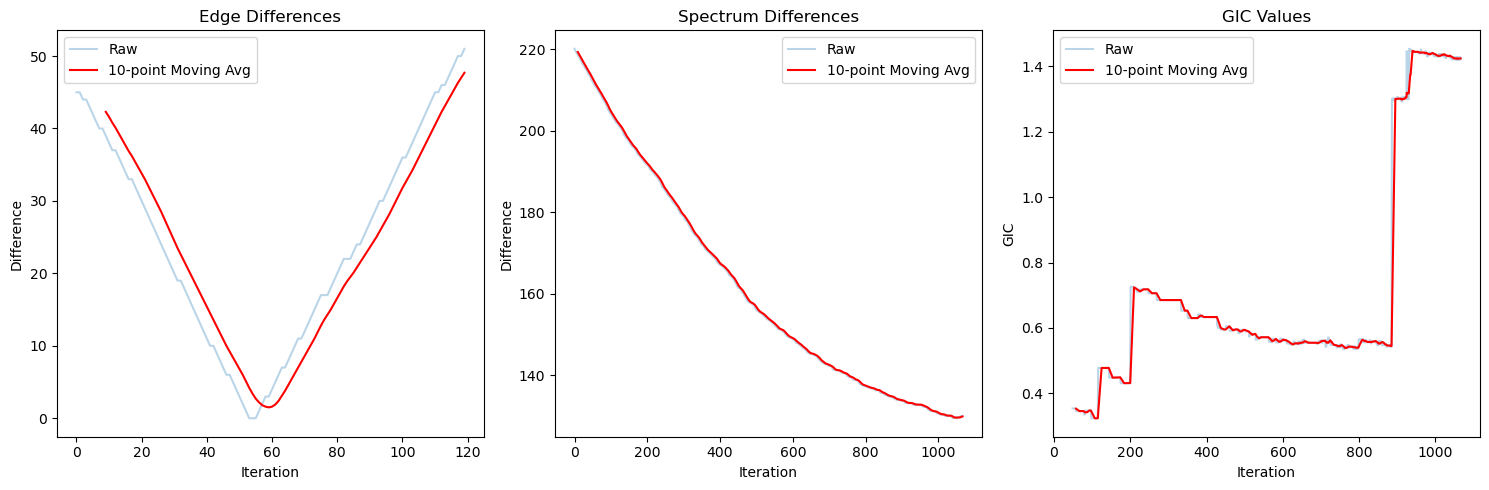

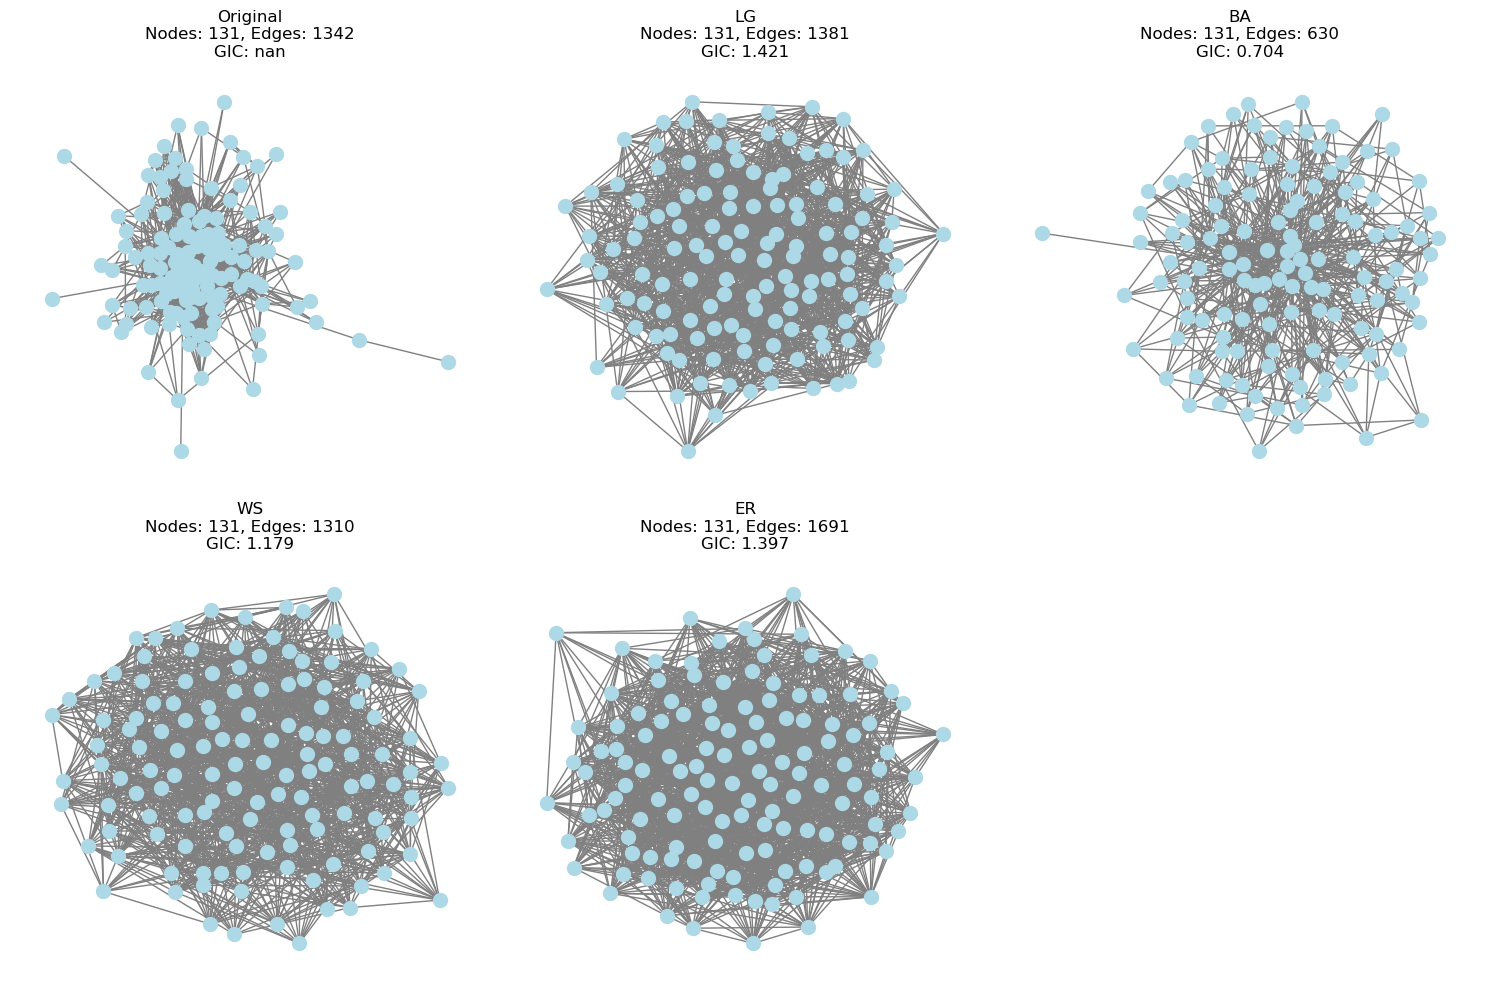

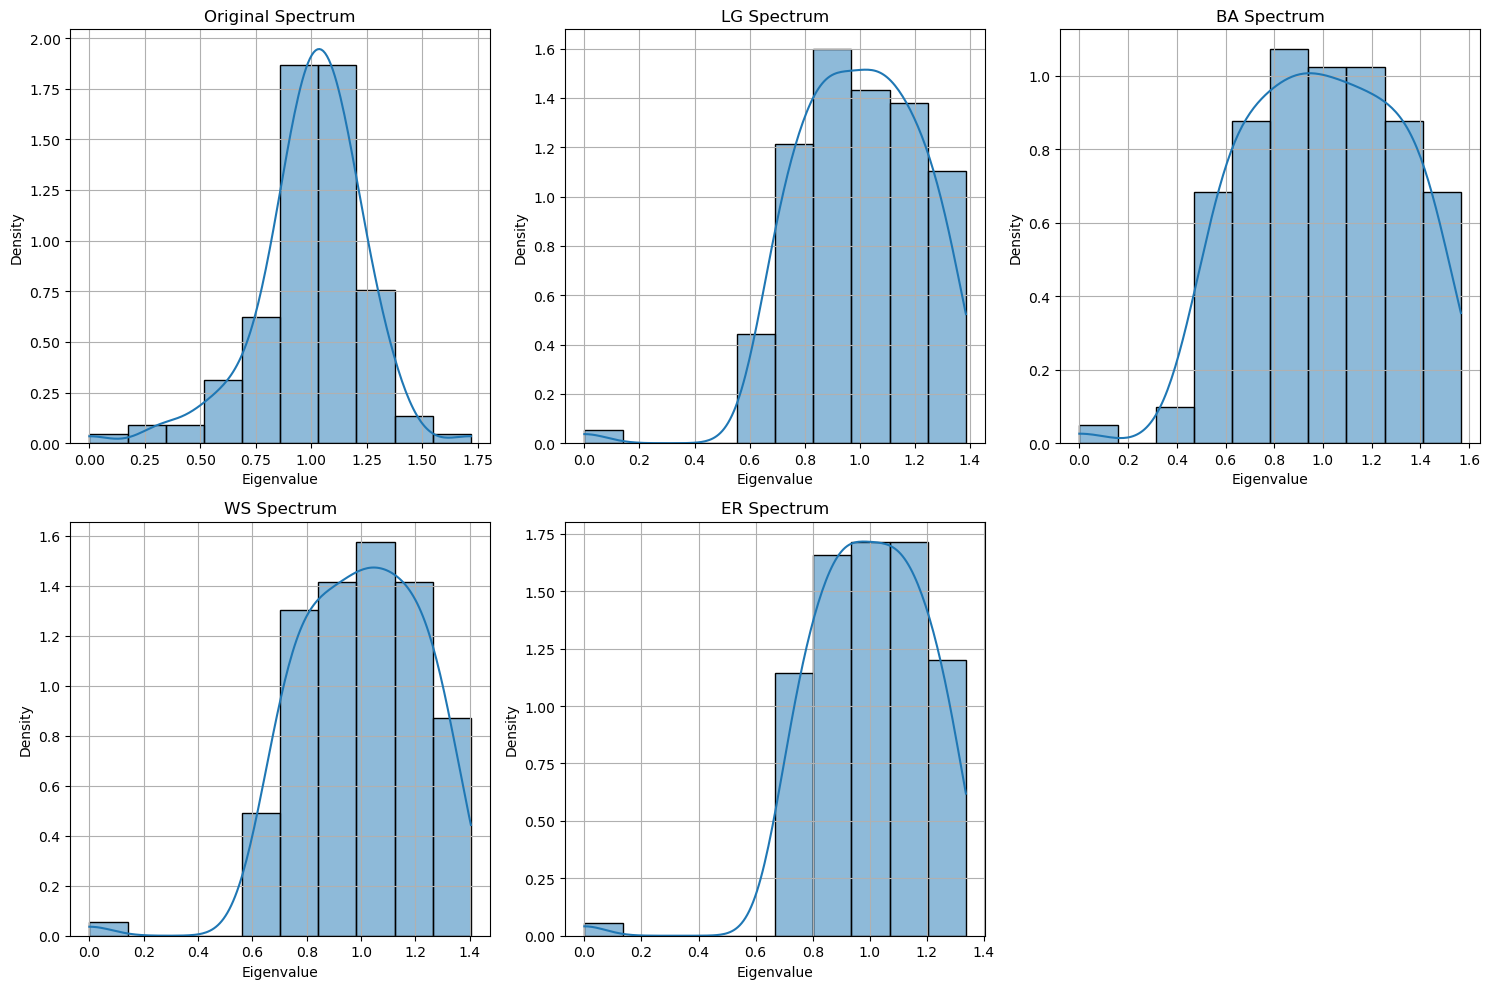

In [13]:
# Gen all plots
os.makedirs(f'imgs', exist_ok=True)
for i in range(len(comparators)):
    if i == 5:
        break
    graph = comparators[i]
    graph_name = f'gplus_{i}'
    print(graph_name)

    #graph = find_comparator_for_connectome('rhesus_cerebral.cortex_1.graphml')
    os.makedirs(f'imgs', exist_ok=True)
    spec_diff = graph.fitted_graphs_data['LG']['metadata']['spectrum_diffs']
    edge_diff = graph.fitted_graphs_data['LG']['metadata']['edge_diffs']
    gic_values = graph.fitted_graphs_data['LG']['metadata']['gic_values']

    # Calculate moving averages with window size of 10
    window = 10
    edge_diff_ma = pd.Series(edge_diff).rolling(window=window).mean()
    spec_diff_ma = pd.Series(spec_diff).rolling(window=window).mean()
    gic_values_ma = pd.Series(gic_values).rolling(window=window).mean()

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.plot(edge_diff, alpha=0.3, label='Raw')
    plt.plot(edge_diff_ma, 'r-', label=f'{window}-point Moving Avg')
    plt.title('Edge Differences')
    plt.xlabel('Iteration')
    plt.ylabel('Difference')
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(spec_diff, alpha=0.3, label='Raw')
    plt.plot(spec_diff_ma, 'r-', label=f'{window}-point Moving Avg')
    plt.title('Spectrum Differences')
    plt.xlabel('Iteration')
    plt.ylabel('Difference')
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(gic_values, alpha=0.3, label='Raw')
    plt.plot(gic_values_ma, 'r-', label=f'{window}-point Moving Avg')
    plt.title('GIC Values')
    plt.xlabel('Iteration')
    plt.ylabel('GIC')
    plt.legend()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'imgs/{graph_name}_iteration.png', bbox_inches='tight', dpi=300)

    plt.show()
    # Get the graph data for each model
    graph_data = graph.fitted_graphs_data

    # Create a figure with subplots for each model
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Plot each graph
    for i, (model, data) in enumerate(graph_data.items()):
        graph2 = data['graph']
        pos = nx.spring_layout(graph2, seed=42)
        
        nx.draw(graph2, pos, ax=axes[i], 
                node_size=100,
                node_color='lightblue',
                edge_color='gray',
                with_labels=False)
        
        # Add title with model name and key metrics
        attrs = data['attributes']
        gic = data['metadata'].get('gic_value', 'N/A')
        title = f"{model}\n"
        title += f"Nodes: {attrs['nodes']}, Edges: {attrs['edges']}\n"
        # title += f"Density: {attrs['density']:.2f}\n"
        # title += f"Avg Clustering: {attrs['avg_clustering']:.2f}\n"
        title += f"GIC: {gic:.3f}" if isinstance(gic, float) else f"GIC: {gic}"
        axes[i].set_title(title)

    # Remove extra subplot
    axes[-1].remove()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'imgs/{graph_name}_graph.png', bbox_inches='tight', dpi=300)

    plt.show()
    # Get the graph data for each model
    graph_data = graph.fitted_graphs_data

    # Create a figure with subplots for each model
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Plot spectrum for each graph
    for i, (model, data) in enumerate(graph_data.items()):
        graph = data['graph']
        
        try:
            # Calculate eigenvalues
            L = nx.normalized_laplacian_matrix(graph)
            eigenvalues = np.linalg.eigvals(L.toarray())
            eigenvalues = np.real(eigenvalues)  # Get real parts
            
            # Plot histogram and KDE with reduced number of bins
            sns.histplot(data=eigenvalues, kde=True, ax=axes[i], stat='density', bins=10)
            axes[i].set_title(f"{model} Spectrum")
            axes[i].set_xlabel("Eigenvalue")
            axes[i].set_ylabel("Density")
            axes[i].grid(True)
        except MemoryError:
            axes[i].text(0.5, 0.5, "Memory Error", ha='center', va='center')
            axes[i].set_title(f"{model} Spectrum (Failed)")

    # Remove extra subplot
    axes[-1].remove()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'imgs/{graph_name}_spectrum.png', bbox_inches='tight', dpi=300)

    plt.show()

